In [ ]:
!pip install "flwr[simulation]" "flwr-datasets[vision]" torch torchvision

In [ ]:
# %%
# Install flower and pytouch libraries


# %%
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr_datasets.partitioner import IidPartitioner, PathologicalPartitioner

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

# %% [markdown]
# ### Parameters
#

# %%
# Parameters
NUM_PARTITIONS = 30  # Number of clients
NUM_IID_CLIENTS = 25 # Number of clients with IID data
BATCH_SIZE = 32
FL_ROUNDS = 100
Local_Epochs = 5
NUM_SELECTED_CLIENTS = 20
CLASSES_PER_CLIENT = 2

# %% [markdown]
# # 2.Data Partition
#

# %% [markdown]
# ## Use flower library to partition the dataset
#

Training on cuda
Flower 1.18.0 / PyTorch 2.6.0+cu124


In [ ]:
iid_partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)
iid_fds = FederatedDataset(dataset="cifar10", partitioners={"train": iid_partitioner})

# Create a pathological partitioner with specified number of partitions
pathological_partitioner = PathologicalPartitioner(
    num_partitions=NUM_PARTITIONS, partition_by="label", num_classes_per_partition=CLASSES_PER_CLIENT, class_assignment_mode='first-deterministic'
)
non_iid_fds = FederatedDataset(dataset="cifar10", partitioners={"train": pathological_partitioner})

def load_datasets(partition_id: int):
    if partition_id < NUM_IID_CLIENTS:
        # Load IID dataset
        fds = iid_fds
    else:
        # Load non-IID dataset
        fds = non_iid_fds

    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    # Define PyTorch transforms
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    # Create data loaders
    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    return trainloader, valloader

In [ ]:
def get_testloader():
    # Define PyTorch transforms
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Load test set
    testset = iid_fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return testloader

In [ ]:
label_distributions = []
for client_id in range(NUM_PARTITIONS):
    trainloader, valloader = load_datasets(partition_id=client_id)
    labels = []
    for batch in trainloader:
        labels.extend(batch["label"].tolist())  # Convert tensor to list
    label_counts = {i: labels.count(i) for i in range(10)}  # Count occurrences of each label
    label_distributions.append(label_counts)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

IID data distribution
          0    1    2    3    4    5    6    7    8    9
Client                                                  
0       121  122  124  123  137  148  159  136  126  137
1       136  129  116  121  129  141  141  145  138  137
2       121  129  130  125  137  126  131  159  140  135
3       150  131  126  136  129  136  139  108  127  151
4       128  129  148  132  139  122  136  129  127  143
5       137  126  167  135  138  151  125  124  122  108
6       150  129  126  129  126  126  134  129  140  144
7       145  115  162  137  155  118  136  132  116  117
8       135  125  137  136  130  138  113  150  138  131
9       142  122  126  135  127  141  128  132  141  139
10      129  134  122  128  128  123  165  126  142  136
11      131  141  130  129  137  139  155  116  125  130
12      142  138  122  152  118  122  139  138  119  143
13      130  144  131  139  125  130  129  139  131  135
14      120  153  116  142  131  132  128  147  140  124
15      1

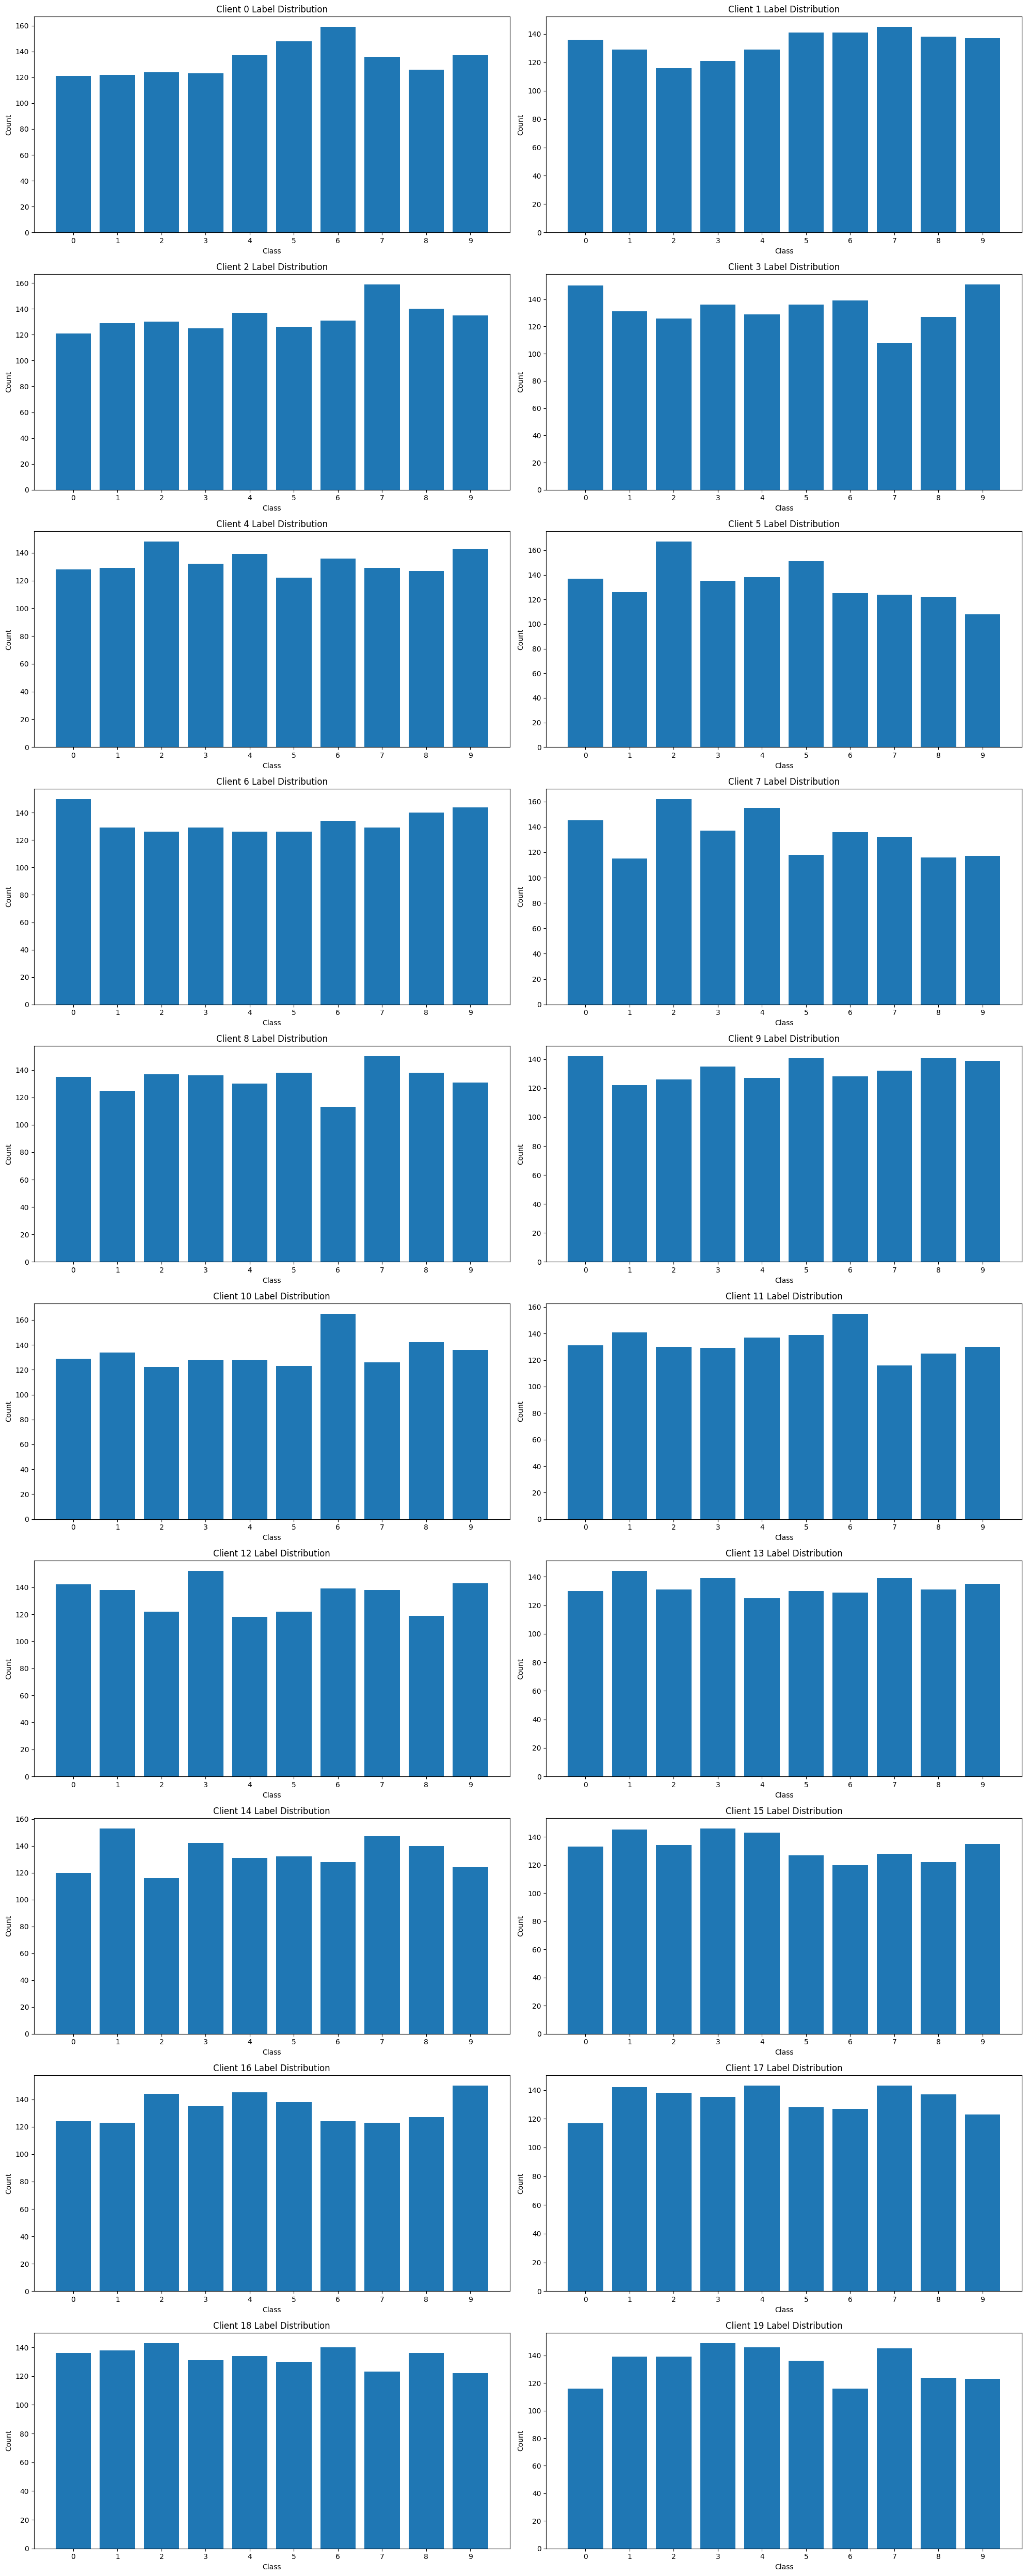

In [ ]:
# %%

# Create a DataFrame from the label distributions
df_label_distributions = pd.DataFrame(label_distributions)

# Set the index to be the client number
df_label_distributions.index.name = 'Client'

# Display the DataFrame
print("IID data distribution")
print(df_label_distributions)

# %%
# Plot label distributions for each client
fig, axs = plt.subplots(10, 2, figsize=(20, 50))
axs = axs.flatten()

for i, (ax, distribution) in enumerate(zip(axs, label_distributions)):
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

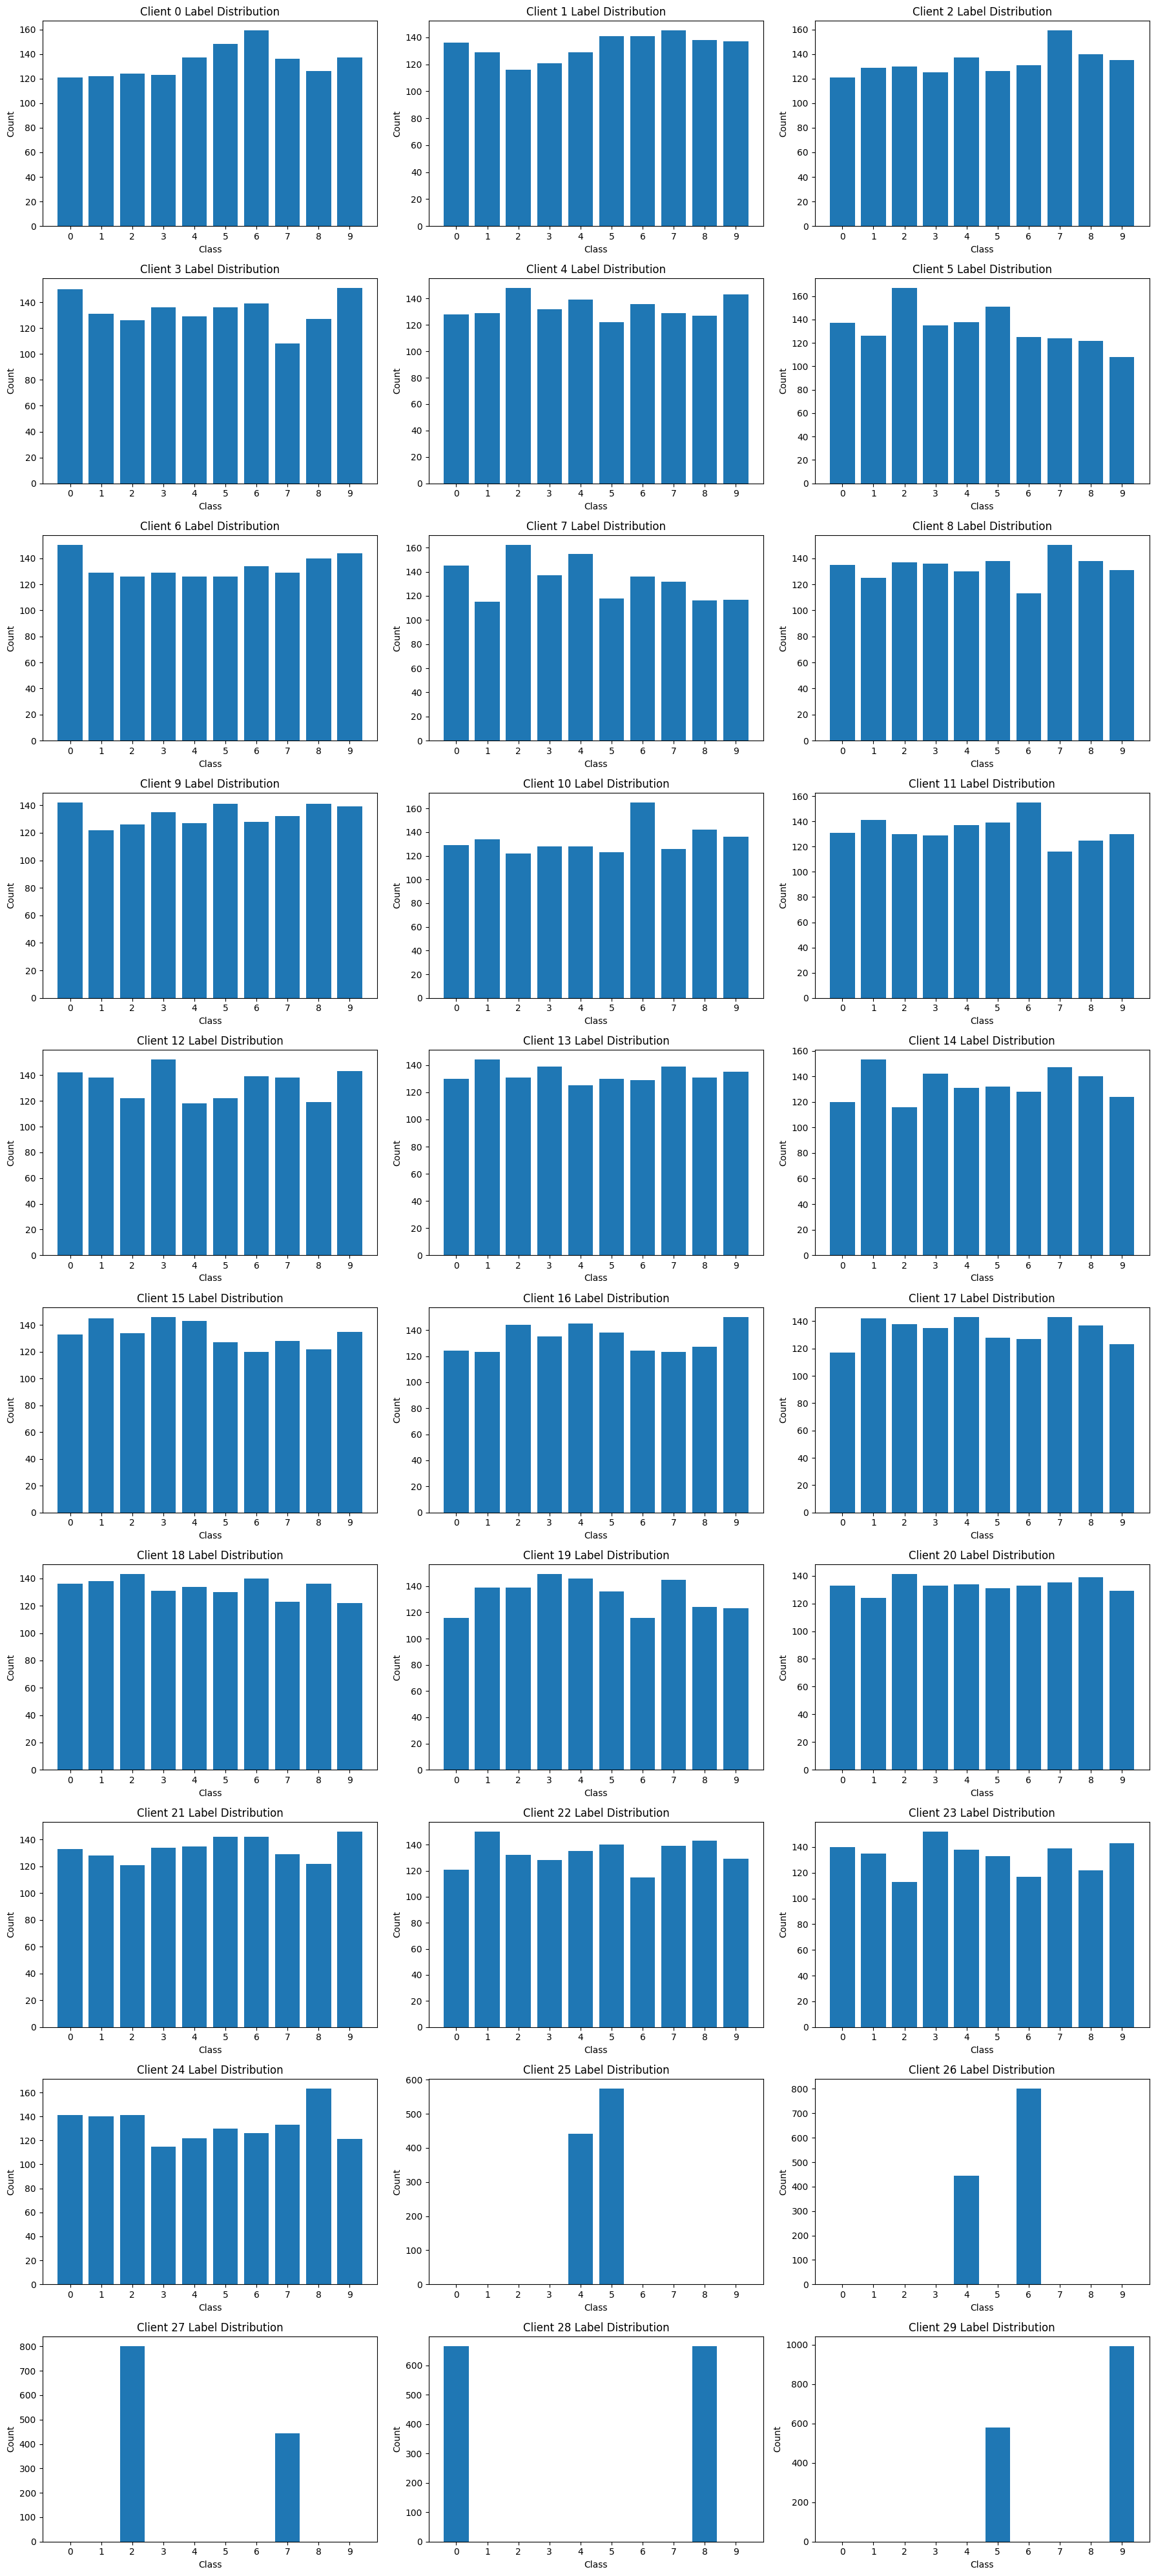

In [ ]:
num_clients = len(label_distributions)
cols = 3  # For example, use 3 columns
rows = (num_clients + cols - 1) // cols  # Ceiling division

fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axs = axs.flatten()

for i, (ax, distribution) in enumerate(zip(axs, label_distributions)):
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import gzip
import os
import torch  # Assuming you are using torch

# Updated parameters
NUM_TOTAL_CLIENTS = 30  # 25 IID + 5 non-IID
NUM_IID_CLIENTS = 25
SAVE_DIR = "./client_datasets"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_client_data(partition_id: int):
    print(f"Saving client {partition_id} data...")
    trainloader, valloader = load_datasets(partition_id)

    # Convert data into list of (image_tensor, label)
    def extract_batches(loader):
        data = []
        for batch in loader:
            images = batch["img"]
            labels = batch["label"]
            for img, lbl in zip(images, labels):
                data.append((img.to(dtype=torch.float16), lbl))
        return data

    client_data = extract_batches(trainloader) + extract_batches(valloader)

    # Determine filename based on IID or non-IID
    if partition_id < NUM_IID_CLIENTS:
        file_index = 25 + partition_id  # Start from 25 to 49
        filename = os.path.join(SAVE_DIR, f"iid_clients_{file_index}.pt.gz")
    else:
        file_index = partition_id - NUM_IID_CLIENTS  # 0–4
        filename = os.path.join(SAVE_DIR, f"client_{file_index}.pt.gz")

    # Save using gzip + float16
    with gzip.open(filename, 'wb') as f:
        torch.save(client_data, f)

    print(f"Saved: {filename}")


In [ ]:
# Save all client datasets
for cid in range(NUM_TOTAL_CLIENTS):
    save_client_data(cid)


Saving client 0 data...
Saved: ./client_datasets/iid_clients_25.pt.gz
Saving client 1 data...
Saved: ./client_datasets/iid_clients_26.pt.gz
Saving client 2 data...
Saved: ./client_datasets/iid_clients_27.pt.gz
Saving client 3 data...
Saved: ./client_datasets/iid_clients_28.pt.gz
Saving client 4 data...
Saved: ./client_datasets/iid_clients_29.pt.gz
Saving client 5 data...
Saved: ./client_datasets/iid_clients_30.pt.gz
Saving client 6 data...
Saved: ./client_datasets/iid_clients_31.pt.gz
Saving client 7 data...
Saved: ./client_datasets/iid_clients_32.pt.gz
Saving client 8 data...
Saved: ./client_datasets/iid_clients_33.pt.gz
Saving client 9 data...
Saved: ./client_datasets/iid_clients_34.pt.gz
Saving client 10 data...
Saved: ./client_datasets/iid_clients_35.pt.gz
Saving client 11 data...
Saved: ./client_datasets/iid_clients_36.pt.gz
Saving client 12 data...
Saved: ./client_datasets/iid_clients_37.pt.gz
Saving client 13 data...
Saved: ./client_datasets/iid_clients_38.pt.gz
Saving client 14

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

# Source and target directories
source_dir = '/content/client_datasets'
target_dir = '/content/drive/MyDrive/client_data_backup2'

# Make sure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Copy each file individually (overwrite if exists)
for filename in os.listdir(source_dir):
    src_file = os.path.join(source_dir, filename)
    dst_file = os.path.join(target_dir, filename)

    if os.path.isfile(src_file):
        shutil.copy2(src_file, dst_file)  # Overwrites if file already exists
        print(f"Copied: {filename}")

print("All client data synced to Google Drive.")


Copied: client_1.pt.gz
Copied: iid_clients_33.pt.gz
Copied: iid_clients_29.pt.gz
Copied: iid_clients_43.pt.gz
Copied: iid_clients_38.pt.gz
Copied: iid_clients_49.pt.gz
Copied: iid_clients_40.pt.gz
Copied: iid_clients_44.pt.gz
Copied: iid_clients_34.pt.gz
Copied: iid_clients_45.pt.gz
Copied: iid_clients_42.pt.gz
Copied: client_4.pt.gz
Copied: iid_clients_26.pt.gz
Copied: iid_clients_39.pt.gz
Copied: iid_clients_31.pt.gz
Copied: iid_clients_35.pt.gz
Copied: iid_clients_37.pt.gz
Copied: iid_clients_41.pt.gz
Copied: client_3.pt.gz
Copied: iid_clients_30.pt.gz
Copied: iid_clients_46.pt.gz
Copied: iid_clients_27.pt.gz
Copied: iid_clients_48.pt.gz
Copied: iid_clients_32.pt.gz
Copied: iid_clients_25.pt.gz
Copied: iid_clients_28.pt.gz
Copied: client_0.pt.gz
Copied: iid_clients_47.pt.gz
Copied: iid_clients_36.pt.gz
Copied: client_2.pt.gz
All client data synced to Google Drive.


# New Section

In [ ]:
import os
import torch
import gzip
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Set this path to your Google Drive directory
save_dir = "/content/drive/MyDrive/client_data_backup2"

# Define batch size globally or pass as a parameter
BATCH_SIZE = 64  # You can adjust this as needed

def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
    if only_server_test_data:
        # Load the original CIFAR-10 test set
        testset = torchvision.datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        )
        testloader = DataLoader(testset, batch_size=BATCH_SIZE, num_workers=8)
        return testloader

    # Try both naming conventions
    client_filenames = [
        os.path.join(save_dir, f'client_{partition_id}.pt.gz'),
        os.path.join(save_dir, f'iid_clients_{partition_id}.pt.gz')
    ]

    # Find which file exists
    for path in client_filenames:
        if os.path.exists(path):
            partition_data_path = path
            break
    else:
        raise FileNotFoundError(f"No data file found for client ID {partition_id} in {save_dir}")

    print(f"Loading client {partition_id} from {partition_data_path}")

    # Load data from file
    with gzip.open(partition_data_path, 'rb') as f:
        device_data = torch.load(f, map_location='cpu')

    # Convert tensors to float32
    device_data = [(x.to(dtype=torch.float32), y) for x, y in device_data]

    # Shuffle and split into train/test (80/20)
    np.random.shuffle(device_data)
    train_size = int(len(device_data) * 0.8)
    train_data = device_data[:train_size]
    test_data = device_data[train_size:]

    # Normalization transform
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    # Apply transform
    train_data = [(normalize(x), y) for x, y in train_data]
    test_data = [(normalize(x), y) for x, y in test_data]

    # Create DataLoaders
    trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
    valloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=1)

    return trainloader, valloader


In [ ]:
from collections import Counter

label_distributions = []
for client_id in range(50):
    trainloader, _ = load_data_from_disk(client_id, False)
    labels = []
    for batch in trainloader:
        if len(batch) != 2:
            raise ValueError(f"Unexpected batch structure: {batch}")
        labels.extend(batch[1].tolist())
    label_distributions.append(Counter(labels))

Loading client 0 from /content/drive/MyDrive/client_data_backup2/client_0.pt.gz
Loading client 1 from /content/drive/MyDrive/client_data_backup2/client_1.pt.gz
Loading client 2 from /content/drive/MyDrive/client_data_backup2/client_2.pt.gz
Loading client 3 from /content/drive/MyDrive/client_data_backup2/client_3.pt.gz
Loading client 4 from /content/drive/MyDrive/client_data_backup2/client_4.pt.gz
Loading client 5 from /content/drive/MyDrive/client_data_backup2/client_5.pt.gz
Loading client 6 from /content/drive/MyDrive/client_data_backup2/client_6.pt.gz
Loading client 7 from /content/drive/MyDrive/client_data_backup2/client_7.pt.gz
Loading client 8 from /content/drive/MyDrive/client_data_backup2/client_8.pt.gz
Loading client 9 from /content/drive/MyDrive/client_data_backup2/client_9.pt.gz
Loading client 10 from /content/drive/MyDrive/client_data_backup2/client_10.pt.gz
Loading client 11 from /content/drive/MyDrive/client_data_backup2/client_11.pt.gz
Loading client 12 from /content/driv

In [ ]:
import matplotlib.pyplot as plt

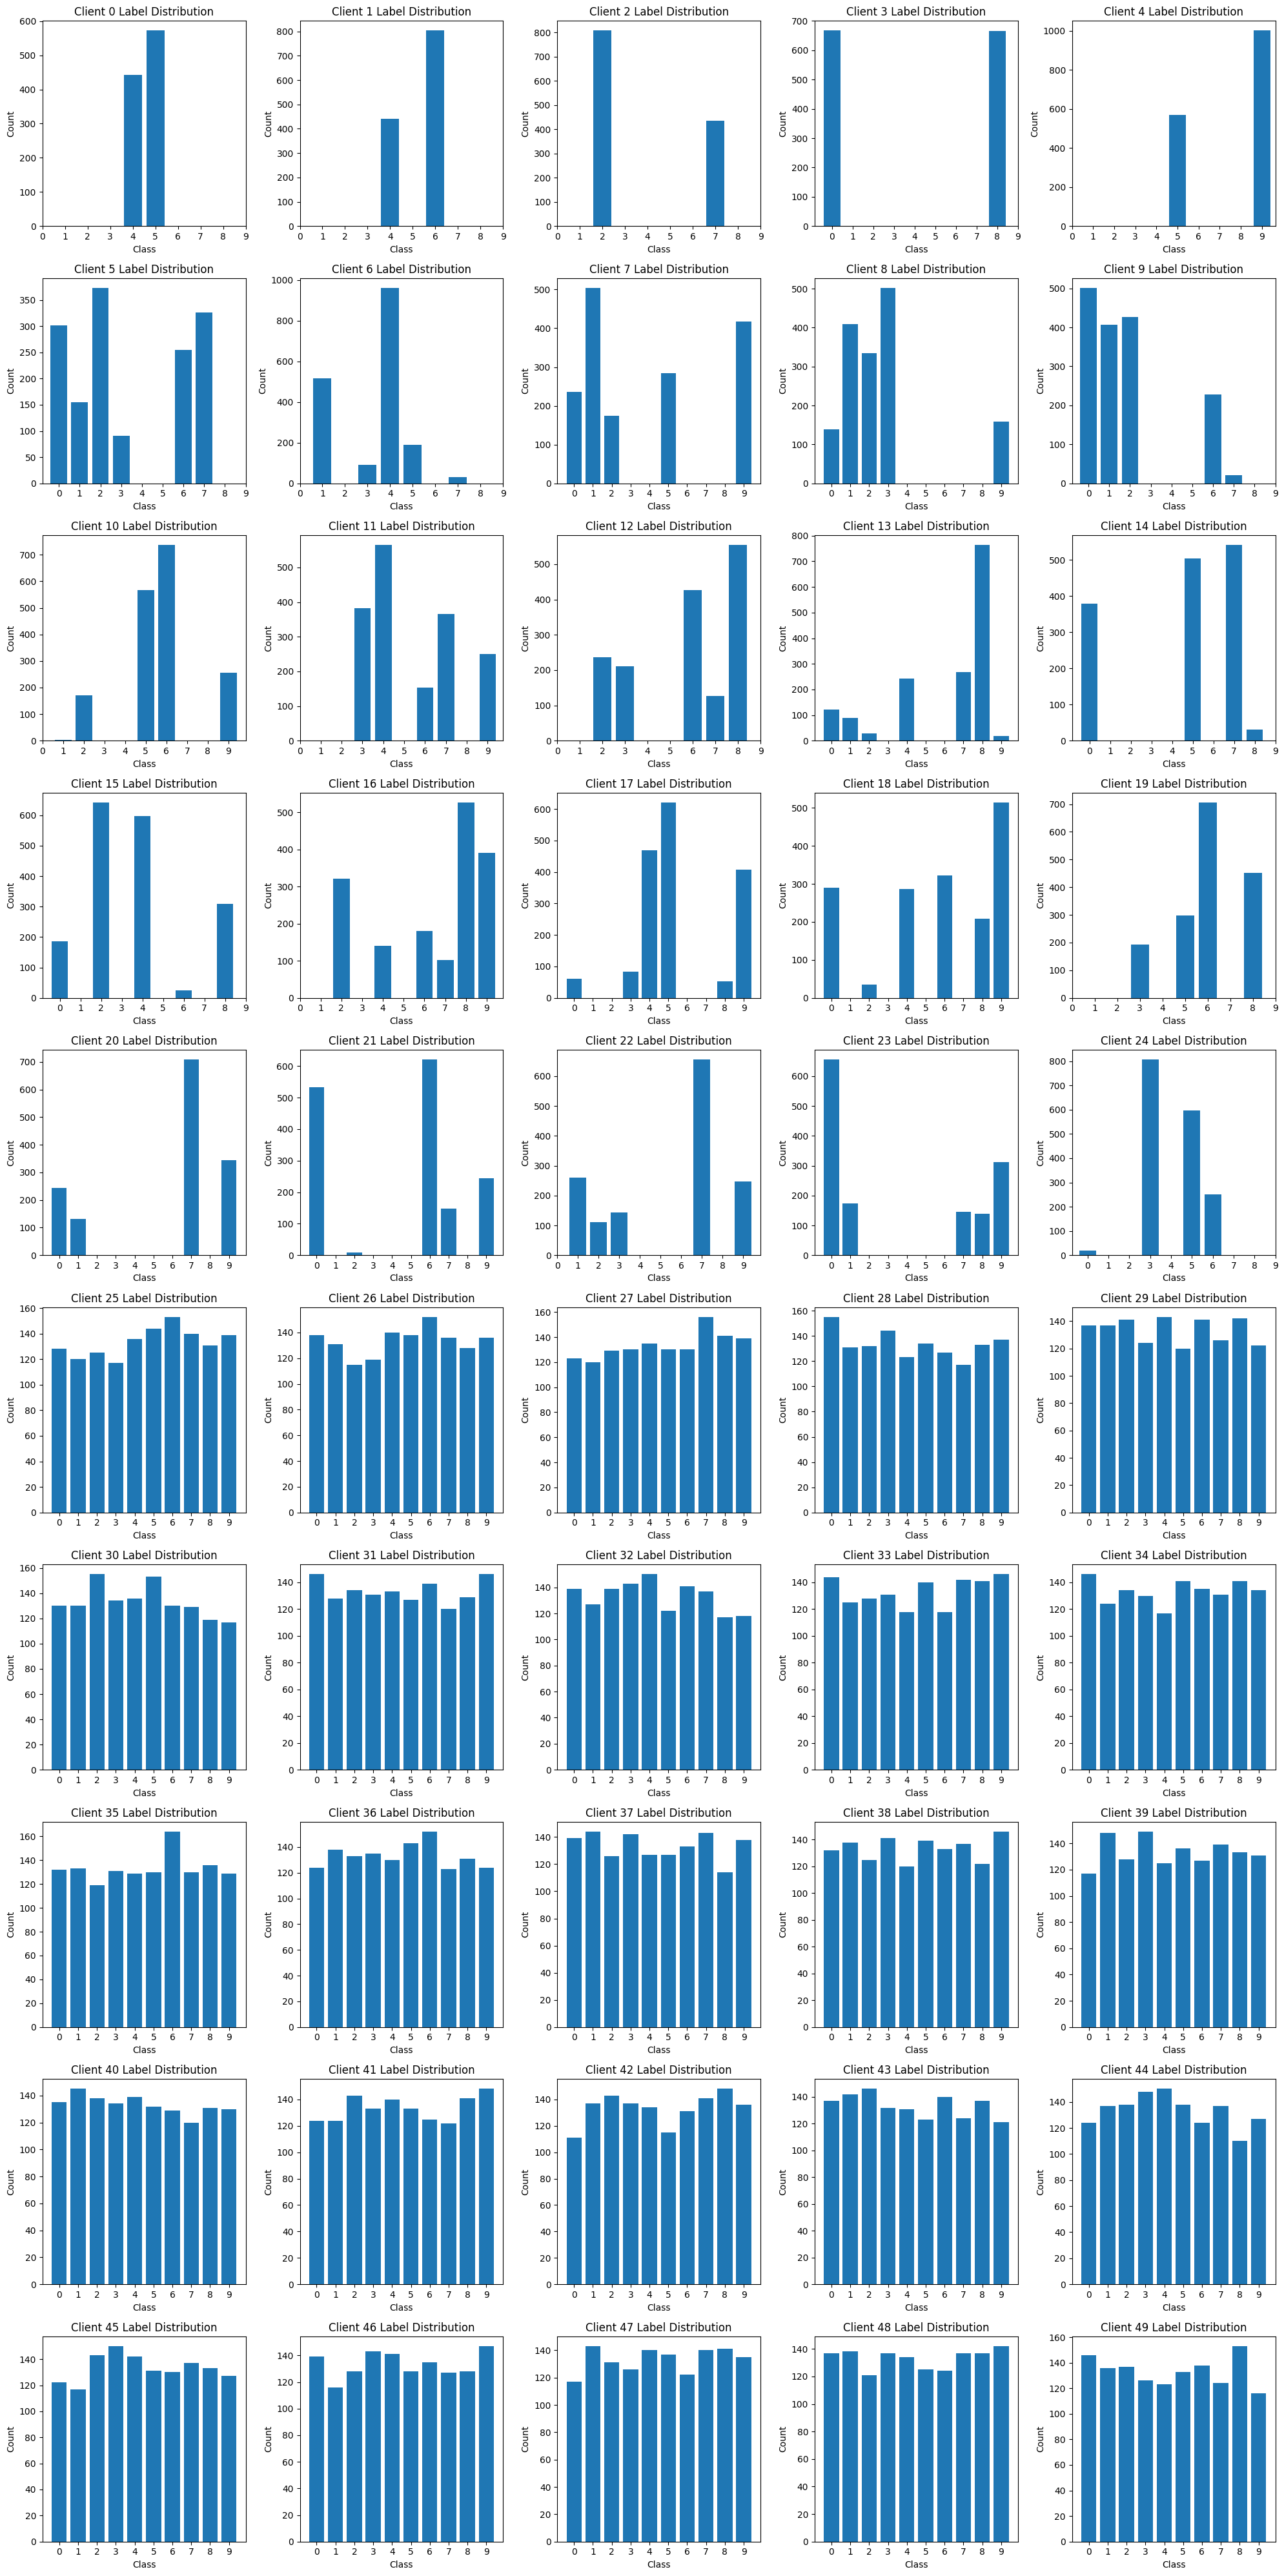

In [ ]:
import matplotlib.pyplot as plt

# Number of clients
num_clients = len(label_distributions)

# Choose subplot grid (e.g., 10 rows × 5 columns = 50 clients)
rows, cols = 10, 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 40))  # Adjust figsize as needed

for i, (ax, distribution) in enumerate(zip(axs.flat, label_distributions)):
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

# Hide any unused subplots (in case you have fewer than 50 clients)
for j in range(num_clients, rows * cols):
    fig.delaxes(axs.flat[j])

plt.tight_layout()
plt.show()
